11350804.825091476
VPL da iniciativa: $11,350,804.83


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


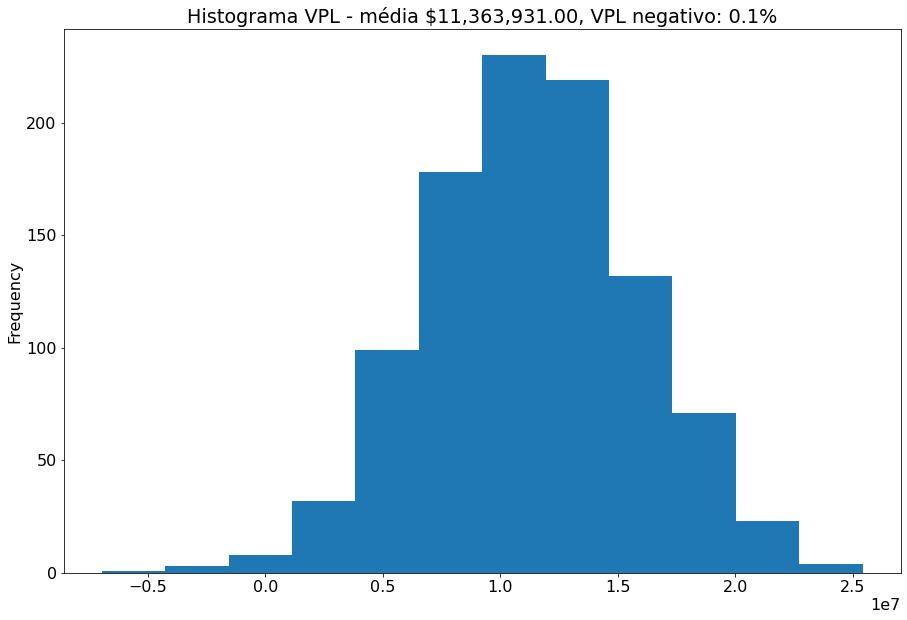

In [2]:
import squarify
import numpy as np
import pandas as pd

class DRE():
  import pandas as pd
  import numpy as np

  def __init__(self, wacc = 0.1, cagr = 0.1, irpf = 0.2, amortizacao = 0, depreciacao = 0, juros = 0, meses_desenvolvimento = 3, horizonte = 60, initial_date = '2021-01-01', crecimento_a_a = 0.02, periodo = 'anual', periodo_ramp_up_receita_default = 6):
    
    self.wacc  = wacc
    self.cagr = cagr
    self.irpf = irpf
    self.amortizacao = amortizacao
    self.depreciacao = depreciacao
    self.juros = juros
    self.meses_desenvolvimento = meses_desenvolvimento  
    self.horizonte = horizonte # Passando de meses para ano
    self.initial_date = initial_date
    self.crecimento_a_a = crecimento_a_a
    self.periodo = periodo
    self.periodo_ramp_up_receita_default = periodo_ramp_up_receita_default

    self.mes_a_mes = pd.date_range(start=self.initial_date, periods = self.horizonte, freq='MS')  
    self.df_receita = pd.DataFrame({'periods': self.mes_a_mes})
    self.df_custo = pd.DataFrame({'periods': self.mes_a_mes})
    self.n_meses_simulacao = len(self.mes_a_mes)

    self.receita_PSRpC = {}
    
    
    self.crecimento_m_m = ((1+self.crecimento_a_a)**(1/12))-1

  def set_custo_infra(self, dict_cost):
    # custo de infra em cada area
    self.custo_infra = dict_cost
    
  def set_custo_hh(self, dict_cost):
      # custo homem hora em cada area
    self.custo_hh = dict_cost

  def adiciona_linha_receita(self, nome, publico, share, receita_por_cliente_mes, periodo_ramp_up_receita = None):

    if periodo_ramp_up_receita == None:
      periodo_ramp_up_receita = self.periodo_ramp_up_receita_default
    
    self.receita_PSRpC[nome] = {'publico': publico, 'share': share, 'receita_por_cliente_mes': receita_por_cliente_mes, 'periodo_ramp_up': periodo_ramp_up_receita}
    
    receita_final = publico * share * receita_por_cliente_mes

    receita_zero = pd.Series([0]*self.meses_desenvolvimento)
    receita_rampup =  pd.Series(np.linspace(start=0, stop=receita_final, num=periodo_ramp_up_receita))
    receita_cruzeiro = pd.Series([receita_final] * (self.n_meses_simulacao - self.meses_desenvolvimento - periodo_ramp_up_receita))
    
    receita_final = receita_zero.append(receita_rampup)
    receita_final = receita_final.append(receita_cruzeiro)
    receita_final.reset_index(inplace = True, drop = True)
        
    self.df_receita['receita_{}'.format(nome)] = receita_final
    
  def custo_desenvolvimento(self, HH_desenvolvimento):
    # concentra custo nos meses_desenvolvimento primeiros meses. 
    #custo_total = self.HH_total_desenvolvimento * self.custo_HH
    self.HH_desenvolvimento = HH_desenvolvimento
    
    for eachkey in HH_desenvolvimento:
      
      hh_distribuido = [self.HH_desenvolvimento[eachkey]/self.meses_desenvolvimento]*self.meses_desenvolvimento
      hh_distribuido = pd.Series(hh_distribuido)
      hh_zero = pd.Series([0]*(self.n_meses_simulacao-self.meses_desenvolvimento))        
      hh_desenvolvimento_distribuido = hh_distribuido.append(hh_zero).reset_index(drop = True)
      
      if eachkey in self.custo_hh:
        nome_col = 'custo_hh_desenvolvimento_naorecorrente_{}'.format(eachkey)
        self.df_custo['custo_hh_desenvolvimento_naorecorrente_{}'.format(eachkey)] = -hh_desenvolvimento_distribuido * self.custo_hh[eachkey]      
      if eachkey in self.custo_infra:
        self.df_custo['custo_infra_desenvolvimento_{}'.format(eachkey)] = -hh_desenvolvimento_distribuido * self.custo_infra[eachkey]
    
    
  def custo_manutencao_hh(self, HH_sustentacao, meses = 1):
    # adiciona custo recorrente para sustentacao
    self.HH_sustentacao = HH_sustentacao
     
    for eachkey in HH_sustentacao:
      
      hh_zero = pd.Series([0]*self.meses_desenvolvimento)
      hh_manutencao = pd.Series([self.HH_sustentacao[eachkey]]*(self.n_meses_simulacao-self.meses_desenvolvimento))        
      hh_manutencao_distribuida = hh_zero.append(hh_manutencao).reset_index(drop = True)
      hh_manutencao_distribuida = hh_manutencao_distribuida.astype(float)
      if eachkey in self.custo_hh:
        self.df_custo['custo_hh_manutencao_recorrente_{}'.format(eachkey)] = -hh_manutencao_distribuida * self.custo_hh[eachkey]      
      if eachkey in self.custo_infra:
        self.df_custo['custo_infra_manutencao_recorrente_{}'.format(eachkey)] = -hh_manutencao_distribuida * self.custo_infra[eachkey]

  def custo_manutencao_outro(self, outros_sustentacao, meses = 1):
    # adiciona custo recorrente para sustentacao
    self.outros_sustentacao = outros_sustentacao
     
    for eachkey in outros_sustentacao:
      
      hh_zero = pd.Series([0]*self.meses_desenvolvimento)
      hh_manutencao = pd.Series([self.outros_sustentacao[eachkey]]*(self.n_meses_simulacao-self.meses_desenvolvimento))        
      hh_manutencao_distribuida = hh_zero.append(hh_manutencao).reset_index(drop = True)
      hh_manutencao_distribuida = hh_manutencao_distribuida.astype(float)
      if eachkey in self.outros_sustentacao:
        self.df_custo['custo_hh_manutencao_recorrente_{}'.format(eachkey)] = -hh_manutencao_distribuida 
        
  
  def compute_dre(self,df_custo, df_receita):

    if self.periodo == 'anual':      
      df_custo['periods'] = df_custo['periods'].apply(lambda x: x.strftime('%Y'))
      df_custo = df_custo.groupby('periods').sum()         
      df_receita['periods'] = df_receita['periods'].apply(lambda x: x.strftime('%Y'))
      df_receita = df_receita.groupby('periods').sum()

    df_custo['CUSTO_TOTAL'] = df_custo.sum(axis=1)
    df_receita['RECEITA_TOTAL'] = df_receita.sum(axis=1)

    df_dre = df_receita.join(df_custo)
    df_dre['cagr'] = -df_dre['RECEITA_TOTAL'] * self.cagr
    df_dre['custo_recorrente']  = df_dre.loc[:, df_dre.columns.str.contains('_recorrente_')].sum(axis=1)
    df_dre['custo_recorrente_cagr'] = df_dre['cagr'] + df_dre['custo_recorrente']
    df_dre['EBITDA'] = df_dre['RECEITA_TOTAL'] + df_dre['custo_recorrente_cagr'] 
    df_dre['amortizacao'] = [-self.amortizacao]*len(df_dre)
    df_dre['depreciacao'] = [-self.depreciacao]*len(df_dre)
    df_dre['EBIT'] = df_dre['EBITDA'] + df_dre['amortizacao'] + df_dre['depreciacao']
    df_dre['imposto'] = -(df_dre['RECEITA_TOTAL'] + df_dre['custo_recorrente_cagr']) * self.irpf
    df_dre['juros'] = [-self.juros]*len(df_dre) 
    df_dre['LUCRO LIQUIDO'] = df_dre['EBIT'] + df_dre['imposto'] + df_dre['juros']

    df_dre['CUSTO NAO RECORRENTE']  = df_dre.loc[:, df_dre.columns.str.contains('_naorecorrente_')].sum(axis=1)

    df_dre['FLUXO_DE_CAIXA'] = df_dre['LUCRO LIQUIDO'] + df_dre['CUSTO NAO RECORRENTE']
    df_dre['ano_desconto'] = np.linspace(1,df_dre.shape[0],df_dre.shape[0])
    df_dre['FLUXO_DE_CAIXA_DESCONTADO'] = df_dre['FLUXO_DE_CAIXA']/((1+self.wacc)**df_dre['ano_desconto'])
    vpl = sum(df_dre['FLUXO_DE_CAIXA_DESCONTADO'])        
    
    return vpl, df_dre      
  
  def dre(self):
    vpl, df_dre = self.compute_dre(self.df_custo.copy(), self.df_receita.copy())
    print("VPL da iniciativa: ${:,.2f}".format(vpl))
    self.df_dre = df_dre
    self.vpl = vpl

    
  def montecarlo(self, iter = 1000):
    import numpy as np
    lista_montecarlo = [None] * iter
    ii=-1
    while ii < iter - 1:
      ii+=1
      df_custo = self.df_custo.copy()
      df_receita = self.df_receita.copy()
      
      df_custo.iloc[:,1:] = df_custo.iloc[:,1:].apply(lambda col: np.random.normal(min(col), abs(min(col))/2, 1)  * col/min(col))      
      df_receita.iloc[:,1:] = df_receita.iloc[:,1:].apply(lambda col: np.random.normal(max(col), max(col)/2, 1)  * col/max(col))

      vpl, _ = self.compute_dre(df_custo, df_receita)
      lista_montecarlo[ii] = vpl
      
    self.montecarlo_df = pd.DataFrame({'iter': range(0,iter), 'vpl': lista_montecarlo})

    mean_vpl = "${:,.2f}".format(round(self.montecarlo_df['vpl'].mean()))
    
    percent_neg = len(np.where(self.montecarlo_df['vpl'] < 0)) / len(self.montecarlo_df['vpl'])
    percent_neg = str(round(100*percent_neg,1))
    
    plot_vpl = self.montecarlo_df['vpl'].plot.hist(bins=12, figsize=(15,10), title = 'Histograma VPL - média ' +mean_vpl + ', VPL negativo: ' + percent_neg + '%')

    return(self.montecarlo_df, plot_vpl)
  
  
  def sensibilidade(self):
    # por enquanto, apenas variacoes default
    from matplotlib.pyplot import figure
    import matplotlib as plt
    figure(num=None, figsize=(12, 9))
    font = {'family' : 'normal',        
            'size'   : 16}

    plt.rc('font', **font)
    
    df_custo = self.df_custo.copy()
    df_receita = self.df_receita.copy()
    lista_sensibilidade = [None] * (len(df_custo.columns) + len(df_receita.columns)-2)
    lista_colunas = [None] * (len(df_custo.columns) + len(df_receita.columns)-2)
    ii=-1
    
      
    for col_custo in df_custo.columns[1:]: # exclui a primeira coluna do periodo
      ii+=1
      df_custo = self.df_custo.copy()
      df_receita = self.df_receita.copy()   
      df_custo[col_custo] = df_custo[col_custo]*1.1
      
      vpl_plus, _ = self.compute_dre(df_custo, df_receita)
      
      df_custo = self.df_custo.copy()
      df_receita = self.df_receita.copy()    
      df_custo[col_custo] = df_custo[col_custo]*0.9
      vpl_minus, _ = self.compute_dre(df_custo, df_receita)
      
      lista_sensibilidade[ii] = (vpl_plus - vpl_minus)/20
      lista_colunas[ii] = col_custo

    
    for col_receita in df_receita.columns[1:]: # exclui a primeira coluna do periodo
      ii+=1
      df_custo = self.df_custo.copy()
      df_receita = self.df_receita.copy()     
      df_receita[col_receita] = df_receita[col_receita]*1.1
      vpl_plus, _ = self.compute_dre(df_custo, df_receita)
      
      df_custo = self.df_custo.copy()
      df_receita = self.df_receita.copy()    
      df_receita[col_receita] = df_receita[col_receita]*0.9
      vpl_minus, _ = self.compute_dre(df_custo, df_receita)
      
      lista_sensibilidade[ii] = (vpl_plus - vpl_minus)/2
      lista_colunas[ii] = col_receita
      
    self.sensibilidade_df = pd.DataFrame({'item': lista_colunas, 'sensibilidade': lista_sensibilidade})
    self.sensibilidade_df = self.sensibilidade_df.sort_values(by = 'sensibilidade', ascending = False)
    
    

    sizes=100*abs(self.sensibilidade_df['sensibilidade'])/sum(abs(self.sensibilidade_df['sensibilidade']))
    label=self.sensibilidade_df['item']
    sizes = round(sizes,1)
    label = label.loc[sizes>0]
    sizes = sizes.loc[sizes>0]

    sizes = list(sizes)
    label = list(label)
    squarify.plot(sizes = sizes,label=label)
    plt.axis('off')
    plt.show()

    
    return(self.sensibilidade_df)


## CUSTO
# Definição de Custo de Desenvolvimento e Sustentação (HH)
HH_desenvolvimento = {
  'dados': 1000, 
  'tech': 1000, 
  'marketing': 400
}

# Sustentacao, custo por mes
HH_sustentacao = {
  'tech': 10
}

custo_infra_por_hora = {
  'dados': 30,
  'tech': 30
}

custo_hh_por_hora = {
  'dados': 100,
  'tech': 100,
  'ux': 100,
  'outros': 100
}

# Custos Marketing
outros_custos_sustentacao = {
  'marketing': 5000
}

## RECEITA
linha_receita_1 = {
  'nome': 'venda produto',
  'publico': 10000,
  'share': 0.13,
  'receita_por_cliente_mes': 100,
  }

linha_receita_2 = {
  'nome': 'suporte produto',
  'publico': 5000,
  'share': 0.40,
  'receita_por_cliente_mes': 150
  }


teste_dre = DRE()
teste_dre.set_custo_infra(custo_infra_por_hora)   
teste_dre.set_custo_hh(custo_hh_por_hora)
teste_dre.custo_desenvolvimento(HH_desenvolvimento)
teste_dre.custo_manutencao_hh(HH_sustentacao)
teste_dre.custo_manutencao_outro(outros_custos_sustentacao)
teste_dre.adiciona_linha_receita(**linha_receita_1)
teste_dre.adiciona_linha_receita(**linha_receita_2)
teste_dre.dre()

teste_dre.df_dre.T

df_mc, plot_vpl = teste_dre.montecarlo()

In [4]:
teste_dre.df_dre.T

periods,2021,2022,2023,2024,2025
receita_venda produto,780000.0,1.560000e+06,1.560000e+06,1.560000e+06,1.560000e+06
receita_suporte produto,1800000.0,3.600000e+06,3.600000e+06,3.600000e+06,3.600000e+06
RECEITA_TOTAL,2580000.0,5.160000e+06,5.160000e+06,5.160000e+06,5.160000e+06
custo_hh_desenvolvimento_naorecorrente_dados,-100000.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
custo_infra_desenvolvimento_dados,-30000.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
custo_hh_desenvolvimento_naorecorrente_tech,-100000.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
custo_infra_desenvolvimento_tech,-30000.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
custo_hh_manutencao_recorrente_tech,-9000.0,-1.200000e+04,-1.200000e+04,-1.200000e+04,-1.200000e+04
custo_infra_manutencao_recorrente_tech,-2700.0,-3.600000e+03,-3.600000e+03,-3.600000e+03,-3.600000e+03
custo_hh_manutencao_recorrente_marketing,-45000.0,-6.000000e+04,-6.000000e+04,-6.000000e+04,-6.000000e+04


TypeError: 'module' object is not callable

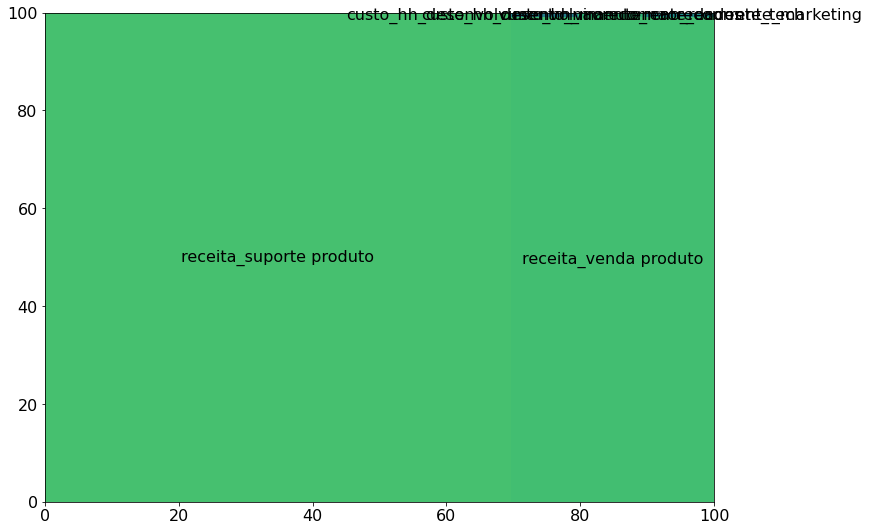

In [3]:
teste_dre.sensibilidade()